In [36]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np

In [37]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


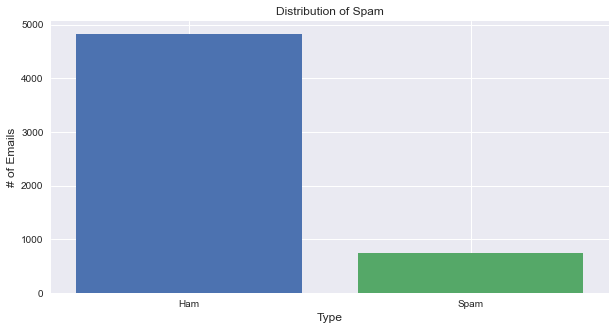

In [19]:
plt.figure(figsize=(10, 5))
plt.bar('Ham', len(df_spam[df_spam['Category']=='ham']))
plt.bar('Spam', len(df_spam[df_spam['Category']=='spam']))

plt.title('Distribution of Spam', size=12)
plt.xlabel('Type', size=12)
plt.ylabel('# of Emails', size=12);

In [16]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

In [18]:
df_spam.Message = df_spam.Message.apply(remove_stopwords)
df_spam.head()

,Category,Message,spam
0,ham,"Go jurong point, crazy.. Available bugis great...",0
1,ham,Ok lar... Joking wif oni...,0
2,spam,Free entry wkly comp win FA Cup final tkts 21s...,1
3,ham,dun say early hor... already say...,0
4,ham,"Nah think goes usf, lives around though",0


In [22]:
X = df_spam['Message']
y = df_spam['spam']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [24]:
import re

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        
        i = re.sub('<[^>]*>', '', i)
        i = re.sub(r'[^\w\s]','', i)
        i = re.sub(r'\$\w*','', i)
        i = re.sub(r'^RT[\s]+','', i)
        i = re.sub(r'http\S+','', i)
        i = re.sub(r'#','', i)
        
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [44]:
vocab_size = 100000
embedding_dim = 64
max_length = 768
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [5]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [31]:
X_train_bert = get_sentence_embeding(X_train)
X_test_bert = get_sentence_embeding(X_test)

In [32]:
X_train_bert.shape

TensorShape([4457, 768])

In [38]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Build Model

## LSTM

In [45]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(1, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 768, 64)           6400000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 768, 128)         66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 768, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,507,329
Trainable params: 6,507,329
No

In [46]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [47]:
history = model.fit(X_train_bert, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


InvalidArgumentError:  indices[10,127] = -1 is not in [0, 100000)
	 [[node sequential_1/embedding_1/embedding_lookup
 (defined at C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\layers\embeddings.py:191)
]] [Op:__inference_train_function_76370]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_1/embedding_1/embedding_lookup:
In[0] sequential_1/embedding_1/embedding_lookup/71931:	
In[1] sequential_1/embedding_1/Cast (defined at C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\layers\embeddings.py:190)

Operation defined at: (most recent call last)
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\UTKARS~1.GOY\AppData\Local\Temp/ipykernel_21004/2426813912.py", line 1, in <module>
>>>     history = model.fit(X_train_bert, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\keras\layers\embeddings.py", line 191, in call
>>>     out = tf.nn.embedding_lookup(self.embeddings, inputs)
>>> 

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

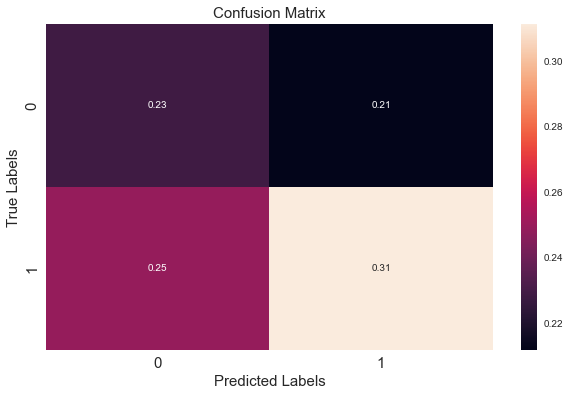

In [40]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

Just using a dense layer is not good enough as the scores are acceptable but not as high as the baseline model.